In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

!pip -q install tensorflow_addons
import tensorflow_addons as tfa

from matplotlib import pyplot as plt
import os
import numpy as np
import shutil

from google.colab import files, drive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Download dan ekstrak dataset

Kode di bawah dapat berjalan jika terdapat file `kaggle.json` yang berisi username dan token dari kaggle API

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


Download dataset, di sini dataset https://www.kaggle.com/datasets/idhamozi/indonesian-sign-language-bisindo/data, yang mengklasifikasikan bahasa isyarat BISINDO





In [5]:
!kaggle datasets download -d idhamozi/indonesian-sign-language-bisindo
!kaggle datasets download -d achmadnoer/alfabet-bisindo
!kaggle datasets download -d yunitayupratiwi/bisindo-dataset



Dataset URL: https://www.kaggle.com/datasets/idhamozi/indonesian-sign-language-bisindo
License(s): copyright-authors
 99% 881M/890M [00:11<00:00, 82.7MB/s]
100% 890M/890M [00:11<00:00, 78.0MB/s]
Dataset URL: https://www.kaggle.com/datasets/achmadnoer/alfabet-bisindo
License(s): CC0-1.0
 95% 109M/115M [00:00<00:00, 119MB/s] 
100% 115M/115M [00:01<00:00, 120MB/s]
Dataset URL: https://www.kaggle.com/datasets/yunitayupratiwi/bisindo-dataset
License(s): unknown
 95% 23.0M/24.1M [00:00<00:00, 121MB/s] 
100% 24.1M/24.1M [00:00<00:00, 111MB/s]


Ekstrak dataset

In [6]:
!unzip -q "/content/alfabet-bisindo.zip" -d "alfabet-bisindo"
# !unzip -q "/content/bisindo-dataset.zip" -d "/content/bisindo-datase"
!unzip -q "/content/indonesian-sign-language-bisindo.zip" -d "indonesian-sign-language-bisindo"



In [9]:
import os

In [15]:
os.remove("/content/alfabet-bisindo.zip")
os.remove("/content/indonesian-sign-language-bisindo.zip")


FileNotFoundError: [Errno 2] No such file or directory: '/content/alfabet-bisindo.zip'

# Load Dataset

Kita akan menggabungkan 3 dataset tersebut pada 1 direktori `DATASET_BASE_DIR`

In [16]:
DATASET_BASE_DIR= '/content/drive/MyDrive/dataCapstone'
TEMP_DATASET_DIR= ['/content/alfabet-bisindo', '/content/indonesian-sign-language-bisindo']

In [17]:
CLASS_LABELS= ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]

In [18]:
for i in CLASS_LABELS:
    try:
        os.makedirs(os.path.join(DATASET_BASE_DIR, i))
    except:
        pass

Memindahkan data gambar ke direktori dataset yang kosong, di sini dibatasi hanya bisa memindahkan maksimal 150 gambar per folder, yang mana `0.08%` dari jumlah rata2 file per folder pada dataset utama yang digunakan.

In [19]:
dummy_idx= 0

for temp_dir in TEMP_DATASET_DIR:
    for dirpath, dirnames, filenames in os.walk(temp_dir):
        parent_dir= os.path.basename(os.path.normpath(dirpath))

        if parent_dir in CLASS_LABELS:
            for idx, i in enumerate(filenames):
                new_file_name= parent_dir+'_unique_'+str(dummy_idx)+'.'+i.split('.')[-1]
                os.rename(os.path.join(dirpath, i), os.path.join(dirpath, new_file_name))

                dummy_idx+= 1

                try:
                    shutil.move(os.path.join(dirpath, new_file_name), os.path.join(DATASET_BASE_DIR, parent_dir, new_file_name))
                except Exception as e:
                    print(e)

                if idx>=150:
                    break

Menginisialisasi beberapa konstan

In [20]:
BATCH_SIZE= 32
RESIZED_IMAGE_SIZE= (224, 224)
RESIZED_IMAGE_SHAPE= RESIZED_IMAGE_SIZE+(3,)

AUTOTUNE= tf.data.experimental.AUTOTUNE

Load dataset dengan `keras.utils.image_dataset_from_directory`

In [21]:
print('Train Data:\n')

ds_train= keras.utils.image_dataset_from_directory(
    directory= DATASET_BASE_DIR,
    batch_size= BATCH_SIZE,
    image_size= RESIZED_IMAGE_SIZE,
    shuffle= True,
    validation_split=0.2,
    subset='training',
    seed= 1,
    labels='inferred',
)

print('\nValidation Data:\n')

ds_val= keras.utils.image_dataset_from_directory(
    directory= DATASET_BASE_DIR,
    batch_size= BATCH_SIZE,
    image_size= RESIZED_IMAGE_SIZE,
    shuffle= True,
    validation_split=0.2,
    subset='validation',
    seed= 1,
    labels='inferred',
)

Train Data:

Found 2391 files belonging to 26 classes.
Using 1913 files for training.

Validation Data:

Found 2391 files belonging to 26 classes.
Using 478 files for validation.


Membuat fungsi normalisasi lalu mengaplikasikannya ke dataset

In [22]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.

    return image, label

Fungsi pembantu untuk menampilkan gambar

In [23]:
ds_train = ds_train.map(normalize, num_parallel_calls=AUTOTUNE)
ds_val= ds_val.map(normalize, num_parallel_calls=AUTOTUNE)

In [24]:
import matplotlib.pyplot as plt

def view_image(ds, class_labels=None, num_plot=(1, 26), figsize=None):
    # Initialize the figure size
    if figsize is None:
        figsize = (num_plot[1] * 3, num_plot[0] * 3)

    # Create the figure
    fig = plt.figure(figsize=figsize)

    # Initialize a dictionary to hold images for each label
    images_dict = {label: [] for label in range(26)}

    # Extract images and labels from the dataset
    for data in ds:
        images, labels = data[0].numpy(), data[1].numpy()
        for img, lbl in zip(images, labels):
            if lbl < 26:
                images_dict[lbl].append(img)
            if all(len(images_dict[i]) > 0 for i in range(26)):
                break
        if all(len(images_dict[i]) > 0 for i in range(26)):
            break

    # Iterate through labels from 'A' to 'Z'
    for i in range(num_plot[0] * num_plot[1]):
        try:
            # Get the corresponding image for the current label
            ax = fig.add_subplot(num_plot[0], num_plot[1], i + 1, xticks=[], yticks=[])
            ax.imshow(images_dict[i][0])  # Select the first image for the label
            if class_labels is not None:
                ax.set_title(f"{class_labels[i]}")
        except IndexError:
            break  # Break the loop if we run out of images

    plt.show()

# Example usage:
# Assuming `ds` is your dataset and `class_labels` is a list of labels from 'A' to 'Z'
# view_image(ds, class_labels=[chr(i) for i in range(65, 91)])


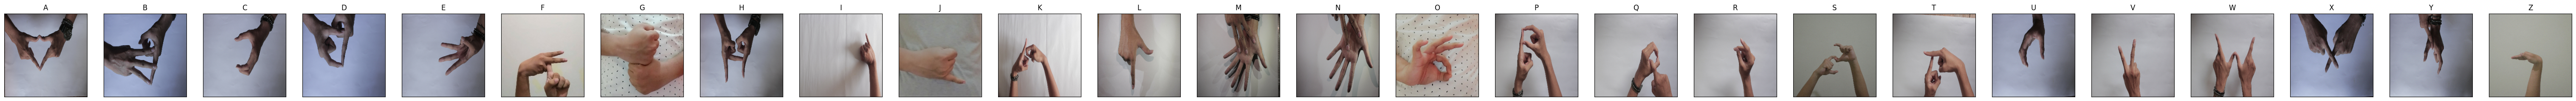

In [25]:
view_image(ds_train, CLASS_LABELS)

Membuat fungsi augmentasi

In [26]:
def augment(image, label):
    if tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32) < 1:
        if tf.random.uniform((), minval=0, maxval=3, dtype=tf.int32) < 2:
            image= tf.image.random_saturation(image, lower=0.5, upper= 2.5)
        else:
            image= tf.tile(tf.image.rgb_to_grayscale(image),[1,1,1,3])

    if tf.random.uniform((), minval=0, maxval=5, dtype=tf.int32) < 1:
        if tf.random.uniform((), minval=0, maxval=2, dtype=tf.int32) < 1:
            image= tf.image.resize(image, (tf.random.uniform((), minval=RESIZED_IMAGE_SIZE[0]//8*5, maxval= RESIZED_IMAGE_SIZE[0]-10, dtype=tf.int32), RESIZED_IMAGE_SIZE[1]))
        else:
            image= tf.image.resize(image, (RESIZED_IMAGE_SIZE[0], tf.random.uniform((), minval=RESIZED_IMAGE_SIZE[1]//8*5, maxval=RESIZED_IMAGE_SIZE[1]-10, dtype=tf.int32)))

        image= tf.image.resize_with_pad(image, RESIZED_IMAGE_SIZE[0], RESIZED_IMAGE_SIZE[1])

    if tf.random.uniform((), minval=0, maxval=3, dtype=tf.int32) < 1:
        image= tfa.image.rotate(image, tf.random.uniform((), minval=-0.8, maxval=0.8, dtype=tf.float32), fill_mode='nearest')

    image = tf.image.random_flip_left_right(image)
    image= tf.clip_by_value(image, 0, 1)

    return image, label

Mengaplikasikan data pipeline pada `ds_train` dan `ds_val`

In [27]:
ds_train = ds_train.map(augment, num_parallel_calls=AUTOTUNE).shuffle(32).cache('/').prefetch(AUTOTUNE)
ds_val= ds_val.cache('/').prefetch(AUTOTUNE)

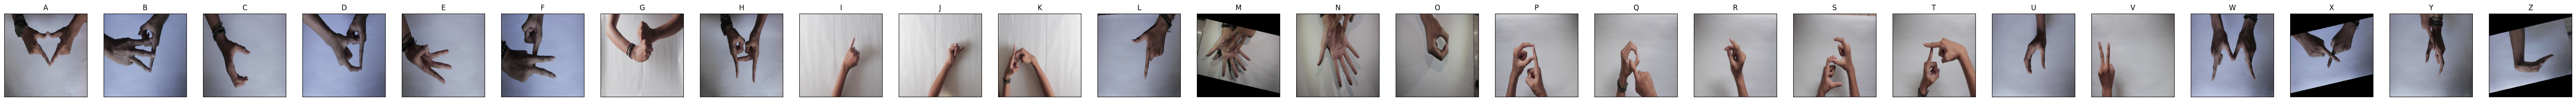

In [28]:
view_image(ds_train, CLASS_LABELS)

# Modeling

Me-load model pre-trained ResNet50V2 tanpa top

In [29]:
base_model = keras.applications.ResNet50V2(
    input_shape=RESIZED_IMAGE_SHAPE,
    include_top=False,
    pooling='max',
    weights = "imagenet"
)

94668760/94668760 [==============================] - 1s 0us/step


Membuat model, tapi terlebih dahulu dilakukan freeze pada `base_model`

In [30]:
base_model.trainable= False
model= keras.models.Sequential()
model.add(base_model)
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(CLASS_LABELS), 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 26)                53274     
                                                                 
Total params: 23618074 (90.10 MB)
Trainable params: 53274 (208.10 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [31]:
optimizer =keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:
reduce_lr= keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor= 0.5, patience=0, min_lr=1e-5, min_delta=0.01)

history = model.fit(ds_train, epochs=5, validation_data=ds_val, batch_size=BATCH_SIZE, callbacks=[reduce_lr])

Epoch 1/5
60/60 [==============================] - 464s 7s/step - loss: 9.1702 - accuracy: 0.3596 - val_loss: 1.5429 - val_accuracy: 0.7875 - lr: 0.0010
Epoch 2/5
60/60 [==============================] - 411s 7s/step - loss: 2.5364 - accuracy: 0.7256 - val_loss: 0.8303 - val_accuracy: 0.8875 - lr: 0.0010
Epoch 3/5
60/60 [==============================] - 406s 7s/step - loss: 1.5337 - accuracy: 0.8014 - val_loss: 0.5393 - val_accuracy: 0.9187 - lr: 0.0010
Epoch 4/5
60/60 [==============================] - 412s 7s/step - loss: 1.0200 - accuracy: 0.8583 - val_loss: 0.4693 - val_accuracy: 0.9396 - lr: 0.0010
Epoch 5/5
60/60 [==============================] - 472s 8s/step - loss: 0.6383 - accuracy: 0.9038 - val_loss: 0.1883 - val_accuracy: 0.9521 - lr: 0.0010


Fine-tuning

In [33]:
base_model.trainable= True

for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable= False

optimizer= keras.optimizers.Adam(learning_rate=1e-5)

model.compile(
    optimizer= optimizer,
    loss= 'sparse_categorical_crossentropy',
    metrics= ['accuracy']
)

In [34]:
ft_history= model.fit(ds_train, epochs=2, validation_data=ds_val, callbacks=[reduce_lr])

Epoch 1/2
60/60 [==============================] - 1290s 21s/step - loss: 0.4707 - accuracy: 0.9174 - val_loss: 0.0328 - val_accuracy: 0.9917 - lr: 1.0000e-05
Epoch 2/2
60/60 [==============================] - 1265s 21s/step - loss: 0.2547 - accuracy: 0.9477 - val_loss: 0.0049 - val_accuracy: 0.9979 - lr: 1.0000e-05


Plot loss dan akurasi training

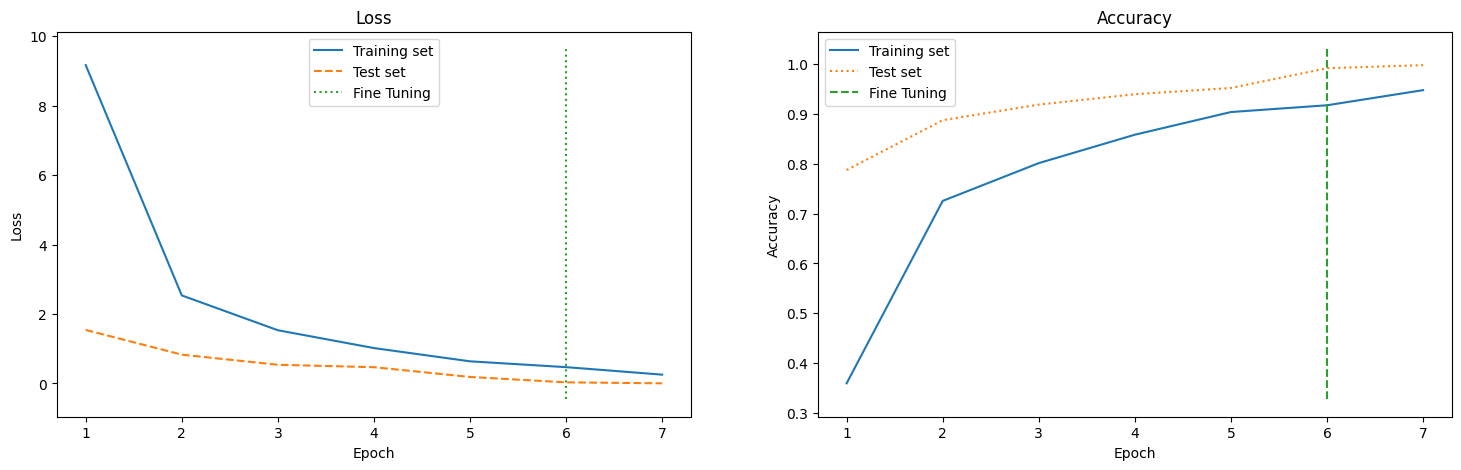

In [35]:
loss = history.history['loss'] + ft_history.history['loss']
val_loss = history.history['val_loss'] + ft_history.history['val_loss']

accuracy = history.history['accuracy'] + ft_history.history['accuracy']
val_accuracy = history.history['val_accuracy'] + ft_history.history['val_accuracy']

plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(list(range(7)), list(range(1,8)))
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.plot([5, 5], plt.ylim(),label='Fine Tuning',linestyle='dotted')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(range(7)), list(range(1,8)))
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Test set', linestyle='dotted')
plt.plot([5, 5], plt.ylim(), label='Fine Tuning', linestyle='--')
plt.legend()

plt.show()

# Evaluasi

Untuk evaluasi, akan digunakan pada data baru yang dibuat secara pribadi.

In [51]:
ds_test= keras.utils.image_dataset_from_directory(
    directory= '/content/drive/MyDrive/dataset/citra_bisindo',
    batch_size= BATCH_SIZE,
    image_size= RESIZED_IMAGE_SIZE,
    shuffle= True,
    seed= 1,
    labels='inferred',
)

ds_test= ds_test.map(normalize)

Found 1638 files belonging to 26 classes.


In [52]:
model.evaluate(ds_test)

52/52 [==============================] - 294s 6s/step - loss: 7.8700 - accuracy: 0.3767


[7.870035648345947, 0.3766788840293884]

In [53]:
def view_image_and_predict(ds, class_labels=None, num_plot=(6,3), figsize=None):
    data = next(iter(ds))
    image = data[0].numpy()
    label = data[1].numpy()

    if figsize is None:
        figsize= (num_plot[1]*3, num_plot[0]*3)

    fig = plt.figure(figsize=figsize)

    for i in range(num_plot[0]*num_plot[1]):
        try:
            ax = fig.add_subplot(num_plot[0], num_plot[1], i+1, xticks=[], yticks=[])
            ax.imshow(image[i])

            predicted= np.argmax(model.predict(tf.expand_dims(image[i], 0)))
            is_correct= 'correct' if predicted==label[i] else 'incorrect'
            ax.set_title(f'predict: {class_labels[int(predicted)]}, true: {class_labels[label[i]]}')
        except:
            pass

1/1 [==============================] - 0s 169ms/step


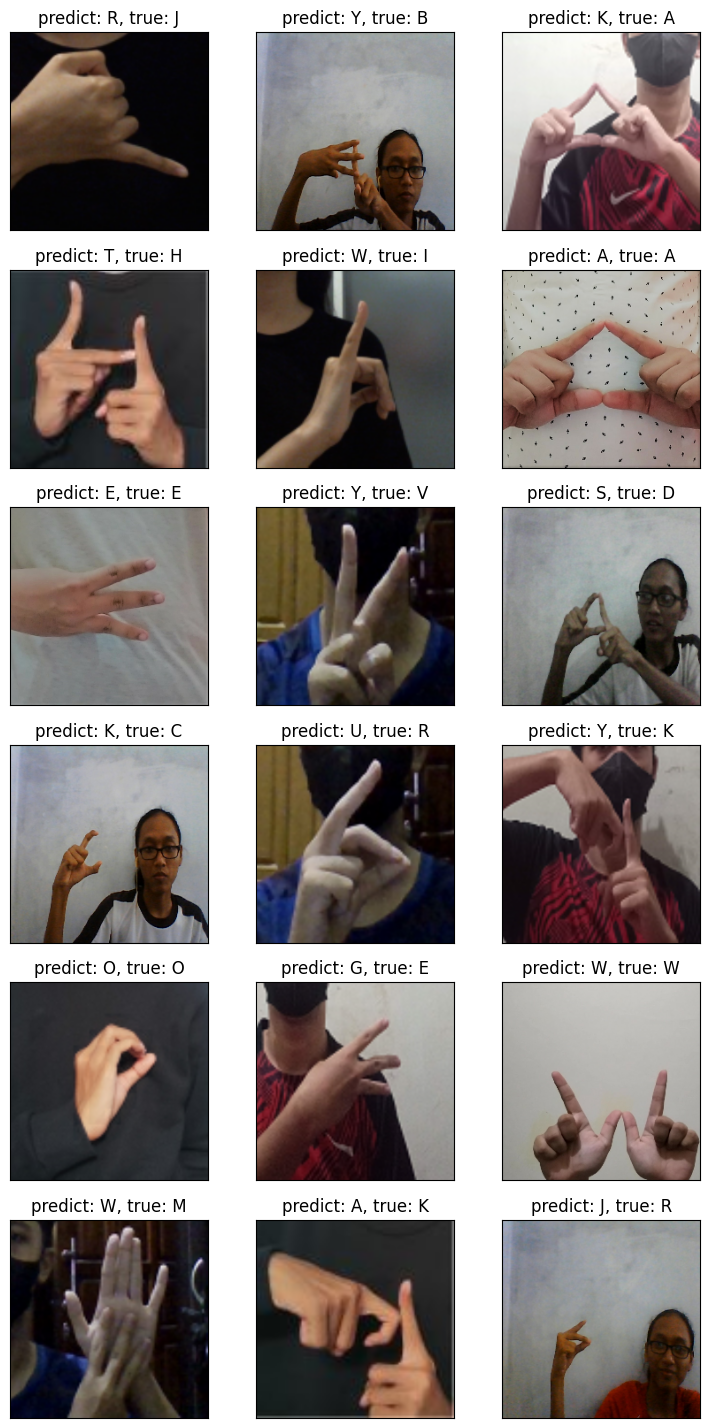

In [54]:
view_image_and_predict(ds_test, CLASS_LABELS)